In [1]:
import pandas as pd
from matplotlib_venn import venn2
import collections
from collections import Counter

#### Defining functions for Histidine kinase (HK) and Response regulator (RR) in TCS operon

In [2]:

# second definition: not sensitive to number of genes in the operon
def get_info(input_list, pmr, ft_i):
    for i in range(1, len(input_list)):
        gene1, gene2 = input_list[i-1:i+1]

        gene1_i = [col.split('_')[-1] for col in pmr.columns if 'product' in col if pmr.loc[index, col].lower() == gene1.lower()][0]
        gene2_i = [col.split('_')[-1] for col in pmr.columns if 'product' in col if pmr.loc[index, col].lower() == gene2.lower()][0]

        gene1_lt, gene2_lt = pmr.loc[index, 'patric_id_%s'%gene1_i], pmr.loc[index, 'patric_id_%s'%gene2_i]

        d1 = get_distance(gene1_lt, gene2_lt, ft_i)


        s1, e1 = ft_i.set_index('patric_id').loc[gene1_lt]['start'], ft_i.set_index('patric_id').loc[gene1_lt]['end']
        s2, e2 = ft_i.set_index('patric_id').loc[gene2_lt]['start'], ft_i.set_index('patric_id').loc[gene2_lt]['end']
        s = min([s1, s2, e1, e2])
        e = max([s1, s2, e1, e2])
        X1 = ', '.join(ft_i.loc[(ft_i['start'] > s) & (ft_i['end'] < e)]['patric_id'].tolist())     

        gene1_l, gene2_l = abs(e1 - s1), abs(e2 - s2)

        gene1_s, gene2_s = ft_i.set_index('patric_id').loc[gene1_lt]['strand'], ft_i.set_index('patric_id').loc[gene1_lt]['strand']

        if i == 1:
            row = {gene1: gene1_lt, '%s length'%gene1: gene1_l, '%s strand'%gene1: gene1_s,
                   gene2: gene2_lt, '%s length'%gene2: gene2_l, '%s strand'%gene2: gene2_s,
                   'D (%s-%s)'%(gene1, gene2):d1, 'X (%s-%s)'%(gene1, gene2):X1}
        else:
            row.update({
                   gene2: gene2_lt, '%s length'%gene2: gene2_l, '%s strand'%gene2: gene2_s,
                   'D (%s-%s)'%(gene1, gene2):d1, 'X (%s-%s)'%(gene1, gene2):X1})
    
    ft_i = ft_i.sort_values(by = 'start')
    gene_order = []
    for gene_lt in list(ft_i['patric_id']):
        gene_name = [pmr.loc[index, 'product_%s'%col.split('_')[-1] ] for col in pmr.columns 
            if 'patric_id' in col if pmr.loc[index, col] == gene_lt]
        if len(gene_name) > 0:
            gene_name = gene_name[0]
        else:
            gene_name = ft_i.loc[ft_i['patric_id'] == gene_lt].fillna('')['gene'].tolist()[0]
            gene_name = 'X' if gene_name == '' else gene_name
        gene_order.append(gene_name)
    gene_order = ', '.join(gene_order)
    row.update({'Gene Order':gene_order})
    return row


def get_distance(gene1, gene2, ft_i):
    strand1, strand2 = ft_i.loc[ft_i['patric_id'] == gene1]['strand'].tolist()[0], ft_i.loc[ft_i['patric_id'] == gene2]['strand'].tolist()[0]
    if strand1 == '+' and strand2 == '+':
        d1 = ft_i.loc[ft_i['patric_id'] == gene2]['start'].tolist()[0] - ft_i.loc[ft_i['patric_id'] == gene1]['end'].tolist()[0]
    elif strand1 == '-' and strand2 == '+':
        d1 = ft_i.loc[ft_i['patric_id'] == gene2]['start'].tolist()[0] - ft_i.loc[ft_i['patric_id'] == gene1]['start'].tolist()[0]
    elif strand1 == '-' and strand2 == '-':
        d1 = ft_i.loc[ft_i['patric_id'] == gene2]['end'].tolist()[0] - ft_i.loc[ft_i['patric_id'] == gene1]['start'].tolist()[0]
    elif strand1 == '+' and strand2 == '-':
        d1 = ft_i.loc[ft_i['patric_id'] == gene2]['end'].tolist()[0] - ft_i.loc[ft_i['patric_id'] == gene1]['end'].tolist()[0]

    return d1

In [3]:
HK_RR = pd.read_csv("../data/blast/hmm_out/a_baumannii_RR_HK_hmm_input.csv", sep="\t")
HK_RR['Genome ID'] = [x.split('|')[-1].split('.peg')[0] for x in HK_RR['patric_id_1']]

HK_RR.head()

,hmm_1,hmm_2,product_1,product_2,patric_id_1,patric_id_2,Genome ID
0,HK,RR,AdeS,AdeR,fig|470.5408.peg.3880,fig|470.5408.peg.3881,470.5408
1,HK,RR,AdeS,AdeR,fig|470.4684.peg.884,fig|470.4684.peg.885,470.4684
2,HK,RR,AdeS,AdeR,fig|470.4759.peg.1628,fig|470.4759.peg.1629,470.4759
3,HK,RR,AdeS,AdeR,fig|470.6368.peg.1767,fig|470.6368.peg.1768,470.6368
4,HK,RR,AdeS,AdeR,fig|470.4777.peg.3234,fig|470.4777.peg.3235,470.4777


#### Function for 03 genes in TCS operon

In [43]:
query = pd.read_csv("../data/blast/pmr/p_aeru_blast_Pmr_out", sep="\s+", skiprows=5, 
                   names = ['query acc.ver', 'subject acc.ver', '% identity', 'alignment length', 'mismatches', 'gap opens', 'q. start', 'q. end', 's. start', 's. end', 'evalue', 'bit score'])
query['Genome ID']= [x.split('|')[-1].split('.peg')[0] for x in query['subject acc.ver']]
tmp = query.groupby('Genome ID')['subject acc.ver','% identity'].max()['subject acc.ver'].tolist()
query = query.set_index('subject acc.ver').loc[tmp]

# merging the 3rd gene in operon

pmr = HK_RR.loc[HK_RR['product_1'] == 'PmrA'].append(HK_RR.loc[HK_RR['product_2'] == 'PmrA'])
directory = '/home/akanksha/akanksha/pan-genomics/data/p_aeru/929_features_tab/'
pmr = pmr.merge(query.reset_index().rename(columns = {'subject acc.ver':'patric_id_3'}), on = 'Genome ID', how = 'inner')
pmr['product_3'] = ['PmrC']*len(pmr)


#input_list = ['KdpD', 'KdpE', 'KdpA','KdpB', 'KdpC']
input_list = ['PmrC', 'PmrA', 'PmrB']
rows = []

for index in pmr.index:
    gid = pmr.loc[index, 'Genome ID']
    ft_i = pd.read_csv('%s/%s.PATRIC.features.tab'%(directory, gid), sep = '\t').set_index('patric_id')

    # step 1: check that they are all on the same contig
    contigs = {ft_i.loc[pmr.loc[index, column_name], 'accession'] for column_name in pmr.columns if 'patric_id' in column_name}
    if len(contigs) >1:
        continue

    ft_i = ft_i.reset_index()
    indices = [ft_i.loc[ft_i['patric_id'] == pmr.loc[index, column_name]].index.tolist()[0] for column_name in pmr.columns if 'patric_id' in column_name]
    ft_i = ft_i.iloc[min(indices):max(indices)+1]
    rows.append(get_info(input_list, pmr, ft_i))

In [44]:
## Check the gene order

FT = pd.DataFrame(rows)
Counter(FT['Gene Order'])


Counter({'PmrC, braZ, X, X, X, X, X, X, X, X, X, X, X, bacA, X, X, X, X, X, X, X, X, rbsK, rbsR, rbsC, rbsA, rbsB, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, rimJ, metE, X, X, X, cobN, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, phzG2, phzF2, phzE2, phzD2, phzC2, phzB2, phzA2, qscR, X, X, X, X, X, X, X, X, X, X, X, X, polB, X, X, X, X, X, X, X, X, X, X, X, X, X, X, lasA, X, X, xqhA, X, X, X, X, X, X, modA, modB, modC, X, X, str, X, X, X, ccoN-2, X, X, X, X, X, X, X, X, X, X, cti, X, X, metH, X, X, X, X, X, X, X, cysI, X, X, X, X, X, X, X, X, X, X, X, X, X, X, nudC, X, X, nhaB, X, X, X, dnaQ, rnhA, X, X, mltD, X, X, X, X, X, fabI, ppiD, X, hupB, lon, clpX, clpP, tig, X, X, X, X, X, X, X, X, X, X, X, folD, cysS, glnS, ppiB, X, X, X, X, X, X, acnB, nasS, nasT, X, X, nasA, X, nirB, nirD, X, cobA, oprF, sigX, X, X, X, X, X, ppsA, X, X, X, X, X, X, X, X, X, X, X, X, X, pabB, thrH, cysH, X, cysB, X, panE, X, aroF-1, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X,

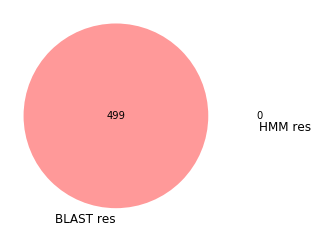

In [14]:
blast_res = set(query['Genome ID'])
HMM_res = set(HK_RR.loc[HK_RR['product_1'] == 'PmrA']['Genome ID'])
HMM_res.update(set(HK_RR.loc[HK_RR['product_2'] == 'PmrA']['Genome ID']))
venn2([blast_res, HMM_res], ['BLAST res', 'HMM res'])

#### Function for >03 genes in TCS operon

In [9]:
# For more than 3 genes

query = pd.read_csv("../data/blast/cus/a_baumannii/a_bauman_cusA_blast_out", sep="\s+", skiprows=5, 
                   names = ['query acc.ver', 'subject acc.ver', '% identity', 'alignment length', 'mismatches', 'gap opens', 'q. start', 'q. end', 's. start', 's. end', 'evalue', 'bit score'])
query['Genome ID']= [x.split('|')[-1].split('.peg')[0] for x in query['subject acc.ver']]
tmp = query.groupby('Genome ID')['subject acc.ver','% identity'].max()['subject acc.ver'].tolist()
query = query.set_index('subject acc.ver').loc[tmp]

# merging the 3rd gene in operon

pmr = HK_RR.loc[HK_RR['product_1'] == 'CusR'].append(HK_RR.loc[HK_RR['product_2'] == 'CusR'])
directory = '/home/akanksha/akanksha/pan-genomics/data/a_baumannii/556_features_tab/'
pmr = pmr.merge(query.reset_index().rename(columns = {'subject acc.ver':'patric_id_3'}), on = 'Genome ID', how = 'inner')
pmr['product_3'] = ['CusA']*len(pmr)

### merge more BLAST results

query = pd.read_csv("../data/blast/cus/a_baumannii/a_bauman_cusB_blast_out", sep="\s+", skiprows=5, 
                   names = ['query acc.ver', 'subject acc.ver', '% identity', 'alignment length', 'mismatches', 'gap opens', 'q. start', 'q. end', 's. start', 's. end', 'evalue', 'bit score'])
query['Genome ID']= [x.split('|')[-1].split('.peg')[0] for x in query['subject acc.ver']]
tmp = query.groupby('Genome ID')['subject acc.ver','% identity'].max()['subject acc.ver'].tolist()
query = query.set_index('subject acc.ver').loc[tmp]
#query.head()

pmr = pmr.merge(query.reset_index().rename(columns = {'subject acc.ver':'patric_id_4'}), on = 'Genome ID', how = 'inner')
pmr['product_4'] = ['CusB']*len(pmr)
#pmr.head()

query = pd.read_csv("../data/blast/cus/a_baumannii/a_bauman_cusC_blast_out", sep="\s+", skiprows=5, 
                   names = ['query acc.ver', 'subject acc.ver', '% identity', 'alignment length', 'mismatches', 'gap opens', 'q. start', 'q. end', 's. start', 's. end', 'evalue', 'bit score'])
query['Genome ID']= [x.split('|')[-1].split('.peg')[0] for x in query['subject acc.ver']]
tmp = query.groupby('Genome ID')['subject acc.ver','% identity'].max()['subject acc.ver'].tolist()
query = query.set_index('subject acc.ver').loc[tmp]
#query.head()

pmr = pmr.merge(query.reset_index().rename(columns = {'subject acc.ver':'patric_id_5'}), on = 'Genome ID', how = 'inner')
pmr['product_5'] = ['CusC']*len(pmr)
#pmr.to_csv("../data/blast/qse_out.csv")


query = pd.read_csv("../data/blast/cus/a_baumannii/a_bauman_cusF_blast_out", sep="\s+", skiprows=5, 
                   names = ['query acc.ver', 'subject acc.ver', '% identity', 'alignment length', 'mismatches', 'gap opens', 'q. start', 'q. end', 's. start', 's. end', 'evalue', 'bit score'])
query['Genome ID']= [x.split('|')[-1].split('.peg')[0] for x in query['subject acc.ver']]
tmp = query.groupby('Genome ID')['subject acc.ver','% identity'].max()['subject acc.ver'].tolist()
query = query.set_index('subject acc.ver').loc[tmp]


pmr = pmr.merge(query.reset_index().rename(columns = {'subject acc.ver':'patric_id_6'}), on = 'Genome ID', how = 'inner')
pmr['product_6'] = ['CusF']*len(pmr)
#pmr.to_csv("../data/blast/kdp/a_baumannii_kdp_merge_out.csv")

In [10]:
pmr.shape

(216, 59)

In [11]:
input_list = ['CusA', 'CusB', 'CusC','CusS', 'CusR','CusF']
#input_list = ['PmrC', 'PmrA', 'PmrB']
rows = []

for index in pmr.index:
    gid = pmr.loc[index, 'Genome ID']
    ft_i = pd.read_csv('%s/%s.PATRIC.features.tab'%(directory, gid), sep = '\t').set_index('patric_id')

    # step 1: check that they are all on the same contig
    contigs = {ft_i.loc[pmr.loc[index, column_name], 'accession'] for column_name in pmr.columns if 'patric_id' in column_name}
    if len(contigs) >1:
        continue

    ft_i = ft_i.reset_index()
    indices = [ft_i.loc[ft_i['patric_id'] == pmr.loc[index, column_name]].index.tolist()[0] for column_name in pmr.columns if 'patric_id' in column_name]
    ft_i = ft_i.iloc[min(indices):max(indices)+1]
    rows.append(get_info(input_list, pmr, ft_i))

In [12]:
FT = pd.DataFrame(rows)
Counter(FT['Gene Order'])


Counter({'CusA, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, rplB, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, X, ilvE, gtrOC1, X, gtrOC2, pda1, gtrOC3, gtrOC4, X, gtrOC8, wecB, gtrOC9, X, aspS, X, X, X, X, X, 

#### Export output file

In [13]:
FT.to_csv("../data/blast/cus/a_baumannii/a_baumannii_cus_final_1.csv")